# Exploration of the Ford-go bike share system for February 2019
## by Christine Shuttleworth

## Investigation Overview

My main interest is which variables predict the length in time of a bike share journey best. This is a useful variable to be able to predict, for forecasting the usage of the bike share system. My aim is going to be finding useful customer subgroups that use the bike share system differently. The investigation aimed to find subgroups based in the user information, geographical information and datetime information. 

## Dataset Overview

The data set includes information about approximately 180 000 individual rides made in a bike-sharing system covering the greater San Francisco Bay area. The data comprises all data points for February 2019. Duration of the trips, start time and location information of the trip and user information of the riders are included in the data set. he data was clean and some data points of riders age, which were impossible were removed. The data contains many outliers, which were incorporated into the analysis.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime as dt
import math
from geopy import Point
from geopy.distance import distance
import gmplot 
from scipy import stats
from scipy.stats import pearsonr

%matplotlib inline

pd.options.display.max_rows=100

base_color = sb.color_palette()[1]
line_color = sb.color_palette()[0]

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [37]:
# load in the dataset into a pandas dataframe
df_bike = pd.read_csv('df_bike_clean.csv')

## Results:

Not many of the subgroups based on the variables investigated, showed pratical differences in mean bike ride duration, e.g. gender, age. There were three noticable subgroups and two areas of interest for further research:

1. Subscribers and as you go customers showed a noticable difference in mean trip duration. 
2. Trip duration and bike hire behaviour also varied with rides taken on weekdays and weekends
3. Trips starting on different times of the day depending on the day of the week also varied

Two areas of further research are:

1. Geographical analysis: There was some trend that showed that trips starting and ending in different areas of San Francisco Bay, varied in trip duration. This could be investigated further, looking at the individual station locations.
2. Roundtrips, i.e. trips that start and end at the same station show two different user groups. One user group, rides the bike on average around 30 min before returning the bike and another rides the bike for only up to 2 min before returning the bike. This warrants further research to find out what motivates the second group and if there is a problem with the bicycle.

## Distribution of bike trip duration with the Ford Bike Share system in the San Francisco Area

Distribution of the trip duration is very highly skewed to the right. The graph below shows the distribution on a log scale, to make the lower value details clearer. The distribution of the duration of the bike trips is unimodal with a spike around 500 seconds (8 min). The distribution is skewed to the right with large outliers. 75 % of the trips are shorter than 13 mins. The longest trip was 23h44 min. 


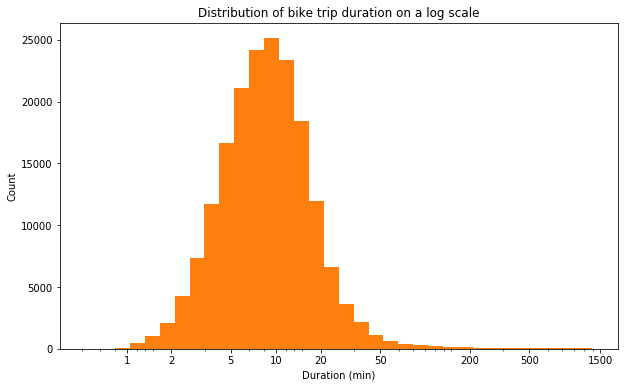

In [38]:
plt.figure(figsize=[10,6])
bins = 10 ** np.arange(1.5,5,0.1)
ticks = [60, 120, 300,600, 1200, 3000, 12000, 30000, 90000]
tick_labels = [1,2,5,10,20,50,200,500,1500]

plt.hist(data=df_bike, x='duration_sec', bins=bins, color=base_color)
plt.xscale('log')
plt.xticks(ticks, tick_labels); #duration_ticks, durations_label
plt.title('Distribution of bike trip duration on a log scale')
plt.xlabel('Duration (min)')
plt.ylabel('Count');

## Average trip duration of users that are subscribers as compared to as you go customers

Most of the bike share users are subscribers (89 %). These have an average trip duration of 11 min. Compared to this, the average trip duration of as you go customers is more than twice as long with 24 min.

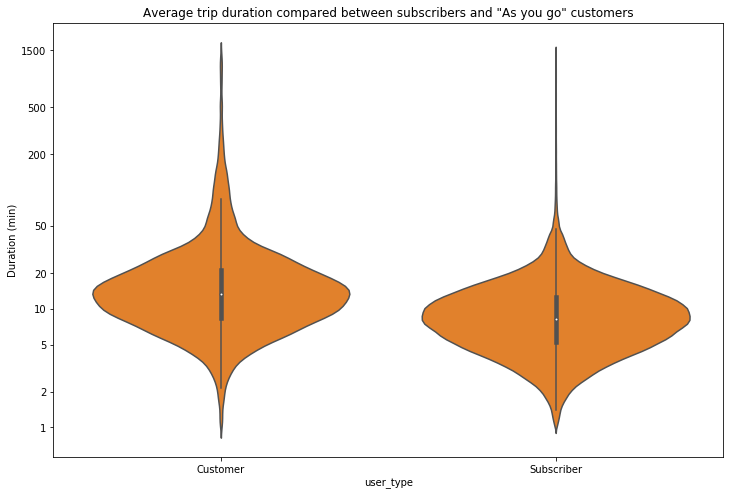

In [59]:
plt.figure(figsize=[12,8])

sb.violinplot(data=df_bike, x='user_type', y=np.log10(df_bike.duration_sec), color=base_color);

plt.yticks(np.log10(ticks), tick_labels)
plt.title('Average trip duration compared between subscribers and "As you go" customers')
plt.ylabel('Duration (min)');

## Number of trips taken on each day of the week

It looks like most trips are taking place during the week.

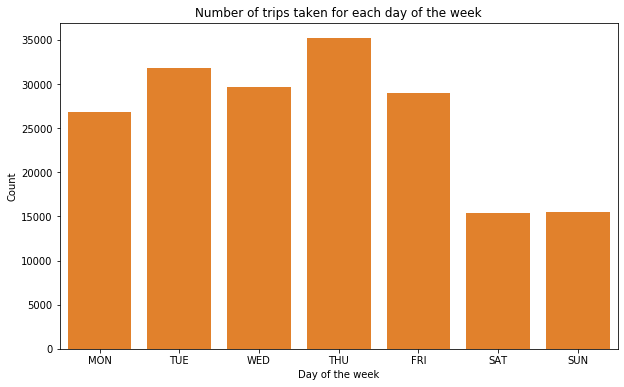

In [39]:
plt.figure(figsize=[10,6])
day_order = ['MON','TUE','WED','THU','FRI','SAT','SUN']
sb.countplot(data=df_bike, x='weekday', color=base_color, order = day_order);
plt.title('Number of trips taken for each day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Count');

## Number of trips started for each hour of the day

Looking at the number of trips starting for each hour of the day, there is a clear difference in usage. During the week, most trips happen during the commuter hours around 8 am in the morning and 5 pm in the afternoon. Whereas on the weekend there is a steady rise of trips during the day with a maximum around lunchtime.

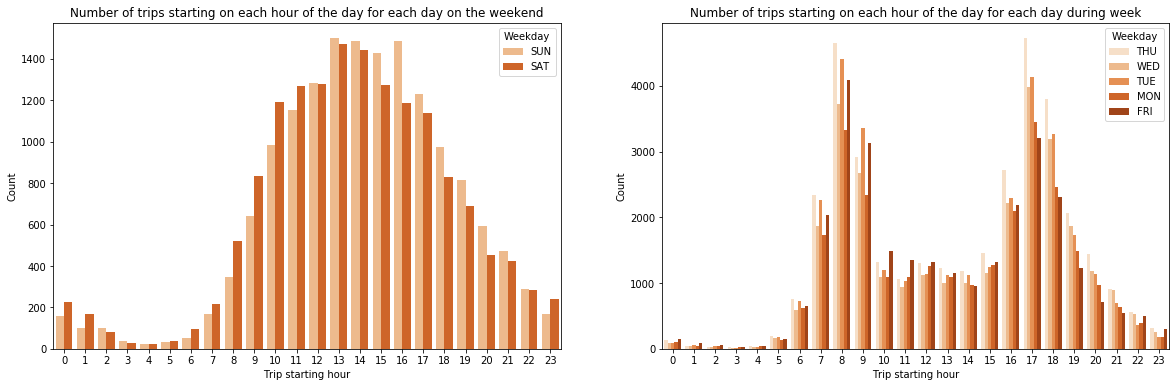

In [40]:
plt.figure(figsize=[20,6])

df_bike_weekend = df_bike.query('weekday in ["SAT", "SUN"]')
df_bike_weekday = df_bike.query('weekday not in ["SAT", "SUN"]')

plt.subplot(1,2,1)
sb.countplot(data=df_bike_weekend, x='trip_start_hour', hue='weekday', palette= 'Oranges')
plt.title('Number of trips starting on each hour of the day for each day on the weekend');
plt.xlabel('Trip starting hour')
plt.ylabel('Count')
plt.legend(title='Weekday');

plt.subplot(1,2,2)
sb.countplot(data=df_bike_weekday, x='trip_start_hour', hue='weekday', palette= 'Oranges');

plt.title('Number of trips starting on each hour of the day for each day during week');
plt.xlabel('Trip starting hour')
plt.ylabel('Count')
plt.legend(title='Weekday');

## Average Duration of bike trips during the day and week

In minutes, the scale show values from 8 min (500 sec) until 15 min (900 sec). There is still a clear trend that trip durations are longer on the weekend and during the weekend there is a peak around the mid of the day on Saturday but more clearly on Sunday. Datapoints before 6 o clock in the morning are few and the values vary quite a bit, because outlier influencing the result. Interestingly, there are also slightly longer trips during monday lunch time. Maybe Monday is a common day off for people working the weekend and it has more leisure trips than other weekdays during the week.

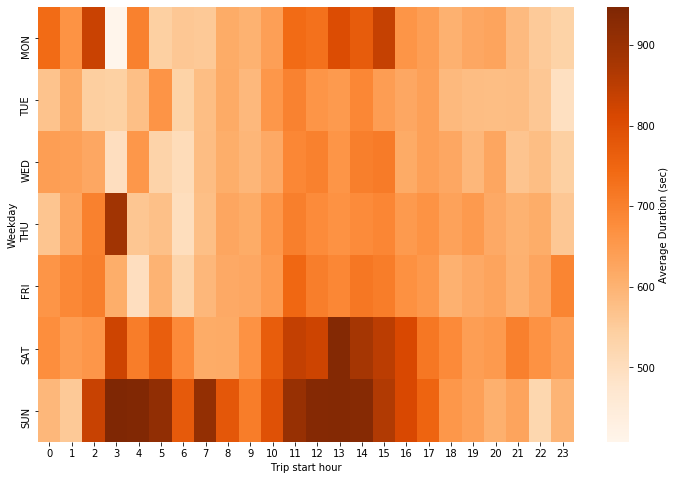

In [41]:
## Duration, Day of week, trip start hour - Looking at trips that lasted less than 3 hours to make the trend clearer.
plt.figure(figsize=[12,8])

weekday_order = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
weekday_cat = pd.api.types.CategoricalDtype(ordered=True, categories = weekday_order)
df_bike['weekday'] = df_bike['weekday'].astype(weekday_cat)

df_bike_sub4 = df_bike.query('duration_sec < 10800')
cat_means = df_bike_sub4.groupby(['trip_start_hour', 'weekday']).mean()['duration_sec']
cat_means = cat_means.reset_index(name='dur_avg')  ## turn data series into dataframe
cat_means = cat_means.pivot(index='weekday', columns='trip_start_hour', values='dur_avg')
cat_means

sb.heatmap(cat_means, fmt='.2f', cbar_kws = {'label' : 'Average Duration (sec)'}, cmap='Oranges')
plt.xlabel('Trip start hour')
plt.ylabel('Weekday');

## Round trips

In the scatterplot below the relationship between distance from the start station to the end station is plotted against the duration of the trip. The lower edge of the graph shows that longer the trip is, the longer the duration. There are however many outliers, where the distance between the starting and end stations is low but the trip took quite a time. One very visible feature of this graph, is where the start and end stations where the same, i.e. distance = 0 km. These I have called round trips.

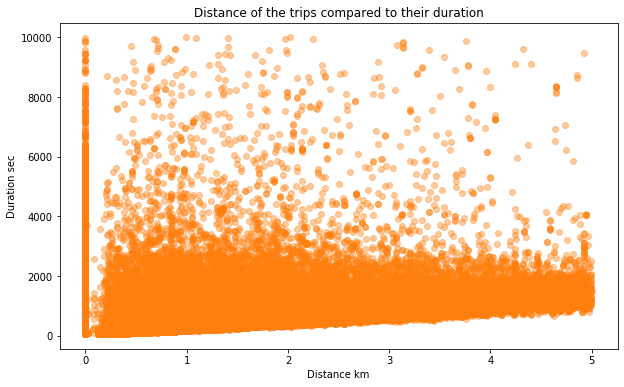

In [62]:
plt.figure(figsize=[10,6])
plt.scatter(data=df_bike.query('distance_km < 5 and duration_sec < 10000'), x='distance_km', y='duration_sec', alpha=0.4, color=base_color)
plt.title('Distance of the trips compared to their duration')
plt.xlabel('Distance km')
plt.ylabel('Duration sec');

## Round trips and duration of the trip per weekday

There are three interesting observations:

Roundtrips are on average longer than trips to a different end station.
Weekend round trips are longer than round trips during the week:
Roundtrips are bimodal. One mode is around 1 - 2 min and another around 30 min. The first user group looks like they are not taking the bike for a ride. I suspect it takes a minute to take the bike away and park it again. They users may start the process of hiring it and then decide against it. Maybe there is a problem with the bike. The second user group rides the bike - most likely for leisure.

Mean trip duration for roundtrips:
- MON:    36 min
- TUE:    27 min
- WED:    25 min
- THU:    27 min
- FRI:    26 min
- SAT:    37 min
- SUN:    43 min

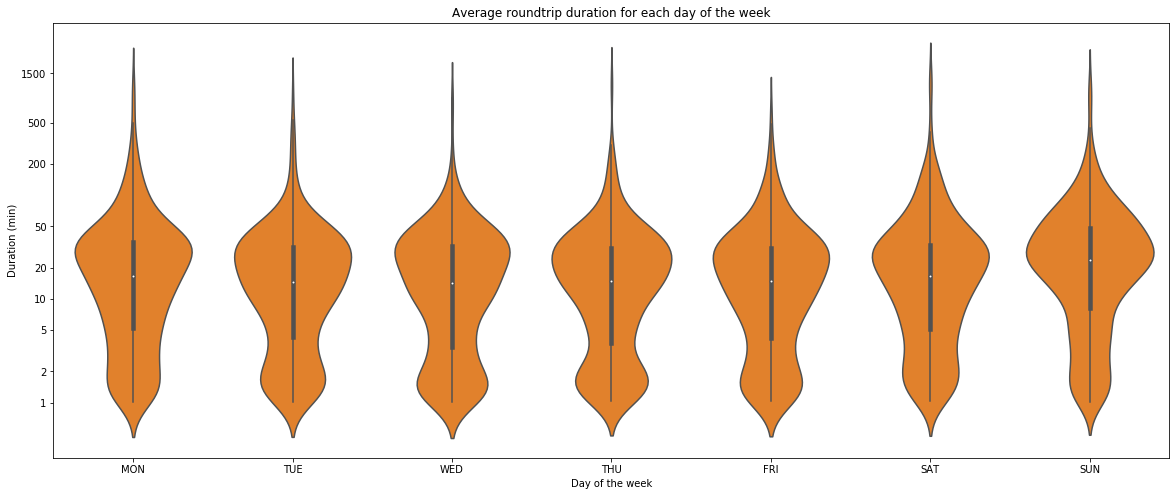

In [49]:
plt.figure(figsize=[20,8])

round_trips = df_bike.query('distance_km == 0')
log_duration_round_trips = np.log10(df_bike.query('distance_km == 0').duration_sec)

sb.violinplot(data=round_trips, x='weekday', y=log_duration_round_trips, color=base_color)
plt.yticks(np.log10(ticks), tick_labels);
plt.title('Average roundtrip duration for each day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Duration (min)');